# Classification Analysis on health condition of nursing home patients
The following program is to illustrate the steps to create an analytics model (or more specifically, a classification model) with a simulated patient dataset consisting of records taken over an estimated 1 year time period.

This dataset represents the <b>vital signs tracked by our proposed wearable IoT device</b> for stay-at-home elderly and people with disabilities, as well as their medical records. Through the various vitals detected by the IoT device and taking into account the patient's medical conditions and past activities, the model will <b>predict whether our patient's condition is normal, at risk or critical</b>.

There are <b>14 input variables</b> and <b>1 target variable</b> - predict if the patient's condition is normal, at risk or critical (y-variable). The variable names and their brief description are as follows:

1) <b>Age</b> (numeric): Age of the patient.

2) <b>Gender</b> (categorical): Gender of the patient (Male/Female).

3) <b>Disability Status</b> (categorical): Whether the patient has a disability (Yes/No).

4) <b>Heart Rate</b> (bpm) (numeric): Beats per minute.

5) <b>Systolic Blood Pressure (mmHg)</b> (numeric): The higher number in a blood pressure reading.

6) <b>Diastolic Blood Pressure (mmHg)</b> (numeric): The lower number in a blood pressure reading.

7) <b>Blood Glucose Level (mg/dL)</b> (numeric): Blood sugar level.

8) <b>Oxygen Saturation (SpO2 %)</b> (numeric): Percentage of oxygen in the blood.

9) <b>Body Temperature (°C)</b> (numeric): Body temperature in Celsius.

10) <b>Chronic Conditions</b> (categorical): Lists any chronic condition that a patient has (if any), otherwise listed as 'None'.

11) <b>Number of Medications</b> (numeric): Number of types of medication that a patient is taking.

12) <b>Activity Level</b> (numeric): Measures how active a patient is (in steps).

13) <b>Smoking Status</b> (categorical): Whether a patient is currently smoking/has smoked before (Yes/No).

14) <b>Alcohol Consumption</b> (categorical): Whether a patient is currently consuming alcohol/has consumed alcohol before (Yes/No).

15) <b>Timestamp</b> (datetime): The date and time of the reading. [NOTE: This is NOT an input variable, it simply denotes the timing at which the record was taken.]

16) <b>Condition</b> (categorical: 'Normal', 'At Risk' or 'Critical'): A classification label indicating the health status (e.g., "Normal", "At Risk", "Critical").

# Part 1: Generating dummy dataset

Below is the source code to simulate our wearable IoT devices taking readings of vitals for the patients.

We first define the normal ranges of the respective vitals, as well as the abnormal thresholds so that our model will be able to predict which category subsequent readings will fall under. (Talk about score system implementation)Afterwards, we classify each reading under one of three categories: 'Healthy', 'At Risk' or 'Critical' based on specific criteria set within the source code.

As for the time period, we chose to generate readings over an estimated 1 year interval with readings taken every hour. This is to increase the accuracy of the model by making use of a sufficiently large dataset, which aims to reduce overfitting by handling more general cases.

In [ ]:
# Import relevant libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Set random seed for reproducibility
np.random.seed(42)

# Number of records (assuming each record is taken hourly, records randomly selected in a 1-year interval)
num_records = 24 * 365

# Generate random timestamps
start_date = datetime(2024,12,31)
end_date = datetime(2025,12,31)
timestamps = []
for i in range(num_records):
    days = np.random.randint(0, (end_date - start_date).days)
    timestamp = start_date + timedelta(days=days) + timedelta(
            hours=np.random.randint(0, 23),
            minutes=np.random.randint(0, 59)
    )
    timestamps.append(timestamp)

# Generate demographic data
age = np.random.randint(60, 90, num_records)  # Age between 60 and 90
gender = np.random.choice(['Male', 'Female'], num_records)
disability_status = np.random.choice(['Yes', 'No'], num_records, p=[0.3, 0.7])  # 30% with disabilities

# Generate vital signs
heart_rate = np.random.randint(50, 120, num_records)
systolic_bp = np.random.randint(90, 180, num_records)
diastolic_bp = np.random.randint(60, 120, num_records)
blood_glucose = np.random.randint(70, 200, num_records)
oxygen_saturation = np.random.randint(85, 100, num_records)
body_temp = np.round(np.random.uniform(36.0, 38.5, num_records), 1)

# Generate medical history
chronic_conditions = np.random.choice(['None', 'Diabetes', 'Hypertension', 'Heart Disease'], num_records, p=[0.4, 0.3, 0.2, 0.1])
num_medications = np.random.randint(0, 10, num_records)

# Generate lifestyle factors
activity_level = np.random.randint(0, 5000, num_records)
smoking_status = np.random.choice(['Yes', 'No'], num_records, p=[0.2, 0.8])
alcohol_consumption = np.random.choice(['Yes', 'No'], num_records, p=[0.3, 0.7])

# Calculate the total score for each patient
def calculate_condition_score(row):
    score = 0

    # Vitals
    if row['Heart Rate'] > 90: score += 1
    if row['Heart Rate'] > 100: score += 2
    if row['Systolic BP'] > 130: score += 1
    if row['Systolic BP'] > 150: score += 2
    if row['Diastolic BP'] > 85: score += 1
    if row['Diastolic BP'] > 95: score += 2
    if row['Blood Glucose'] > 120: score += 1
    if row['Blood Glucose'] > 160: score += 2
    if row['Oxygen Saturation'] < 95: score += 1
    if row['Oxygen Saturation'] < 92: score += 2
    if row['Body Temp'] > 37.5: score += 1
    if row['Body Temp'] > 38.0: score += 2

    # Medical History
    if row['Chronic Conditions'] == 'Diabetes': score += 1
    if row['Chronic Conditions'] == 'Hypertension': score += 1
    if row['Chronic Conditions'] == 'Heart Disease': score += 2

    # Lifestyle Factors
    if row['Smoking Status'] == 'Yes': score += 2
    if row['Alcohol Consumption'] == 'Yes': score += 1
    if row['Activity Level'] < 2000: score += 1  # Low activity level

    return score

# After calculating the score, determine the patient's condition
def generate_condition(row):
    score = calculate_condition_score(row)
    if score >= 9:
        return 'Critical'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Normal'

# Create DataFrame
data = {
    'Age': age,
    'Gender': gender,
    'Disability Status': disability_status,
    'Heart Rate': heart_rate,
    'Systolic BP': systolic_bp,
    'Diastolic BP': diastolic_bp,
    'Blood Glucose': blood_glucose,
    'Oxygen Saturation': oxygen_saturation,
    'Body Temp': body_temp,
    'Chronic Conditions': chronic_conditions,
    'Number of Medications': num_medications,
    'Activity Level': activity_level,
    'Smoking Status': smoking_status,
    'Alcohol Consumption': alcohol_consumption,
    'Timestamp': timestamps
}

df = pd.DataFrame(data)
df['Condition'] = df.apply(generate_condition, axis=1)

# Save to CSV
# df.to_csv('simulated_medical_records.csv', index=False)

In [ ]:
# Ensure that DataFrame is loaded properly with all required values
df

,Age,Gender,Disability Status,Heart Rate,Systolic BP,Diastolic BP,Blood Glucose,Oxygen Saturation,Body Temp,Chronic Conditions,Number of Medications,Activity Level,Smoking Status,Alcohol Consumption,Timestamp,Condition
0,75,Female,No,75,115,82,193,90,37.3,Diabetes,5,2850,No,Yes,2025-04-12 19:28:00,At Risk
1,76,Male,No,86,175,63,160,89,38.4,Heart Disease,2,3464,No,No,2025-09-27 10:07:00,Critical
2,69,Female,No,104,170,77,138,99,36.2,None,5,1968,No,No,2025-07-07 20:38:00,At Risk
3,77,Female,Yes,51,123,71,124,86,37.3,Diabetes,6,2294,No,No,2025-05-01 18:22:00,At Risk
4,71,Male,Yes,68,144,94,144,88,37.5,Diabetes,0,4292,No,Yes,2025-11-26 10:23:00,At Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,77,Female,No,60,112,113,196,86,38.4,Diabetes,3,2851,No,No,2025-05-31 10:45:00,Critical
8756,64,Female,No,52,144,80,76,86,36.7,None,9,1650,No,No,2025-03-22 06:04:00,At Risk
8757,74,Male,Yes,110,108,118,136,90,38.3,None,5,2847,No,No,2025-05-18 21:34:00,Critical
8758,67,Female,No,115,156,113,130,94,36.5,Heart Disease,3,640,No,No,2025-04-21 10:41:00,Critical


In [ ]:
# Descriptive statistics of dataframe
df.describe()

,Age,Heart Rate,Systolic BP,Diastolic BP,Blood Glucose,Oxygen Saturation,Body Temp,Number of Medications,Activity Level,Timestamp
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760
mean,74.477740,84.278082,134.456050,89.632420,134.586644,92.046005,37.244361,4.484817,2506.257534,2025-06-30 10:38:26.219177984
min,60.000000,50.000000,90.000000,60.000000,70.000000,85.000000,36.000000,0.000000,2.000000,2024-12-31 01:38:00
25%,67.000000,67.000000,112.000000,75.000000,101.000000,88.000000,36.600000,2.000000,1255.000000,2025-04-01 05:56:00
50%,74.000000,84.000000,134.000000,90.000000,136.000000,92.000000,37.200000,4.000000,2544.000000,2025-06-29 19:39:00
75%,82.000000,102.000000,157.000000,104.000000,167.000000,96.000000,37.900000,7.000000,3740.250000,2025-09-29 05:27:45
max,89.000000,119.000000,179.000000,119.000000,199.000000,99.000000,38.500000,9.000000,4999.000000,2025-12-30 22:53:00
std,8.635835,20.294623,26.089659,17.170184,37.795374,4.334280,0.726888,2.853943,1435.754546,NaN


# Part 2: Preprocessing the data + Creating the training and test datasets

<b>Data Preprocessing</b>

1) 'Timestamp' column was dropped as it simply denotes the date & time at which the record was tracked; does not help in predicting a patient's condition

2) Dealing with categorical variables: Categorical variables in the dataset are one-hot encoded into True/False variables that can be implicitly converted into binary values (0/1).

3) Separating predictor variables and target variable:
- <b>Predictor variables</b> (X): Gets all the columns in the dataset except for 'Condition' as we are trying to predict the patient's condition.
- <b>Target variable</b> (y): Consists of only 'Condition' column.

4) Standardizing the predictor variables: Since all the predictor variables have different ranges, we need to standardize all of them to the same range of values so that none of the variables will be able to predominantly influence the model.

5) After standardizing all the numerical variables, we separate X and y into training and test datasets.


In [ ]:
# Drop 'Timestamp' column as it won't be needed
df = df.drop(columns=['Timestamp'])

# Encode categorical variables
categorical_cols = ['Gender', 'Disability Status', 'Chronic Conditions', 'Smoking Status', 'Alcohol Consumption']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=['Condition'])
y = df_encoded['Condition']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Part 3: Generate the model

For our model, we will actually be opting for a Random Forest Classifier model over a Logistic Regression model. Here are some reasons why:

1) Handling non-linear relationships: Medical conditions often depend on <b>complex, non-linear interactions</b> between variables. Random Forest Classifier can capture non-linear relationships and interactions between features automatically (via decision trees), while logistic regression often assumes linear relationships between features and the log-odds of the outcome.

2) Automatic feature selection: Not all vitals/history factors are equally important (e.g., smoking status might matter more for some conditions than others). Random Forest Classifier ranks features by importance during training (feature_importances_) and can ignore irrelevant features, while Logistic Regression requires manual feature selection which can degrade performance if irrelevant features are selected.

3) Handling imbalanced data: Medical datasets often have imbalanced classes. Random Forest Classifier supports class weighting (class_weight='balanced') to prioritize minority classes and aggregates predictions across trees, reducing bias toward majority classes. Logistic Regression could also use class weights but is more prone to bias when classes are severely imbalanced.

We first create a RandomForestClassifier model to fit our training dataset and train the model, then we use the model to predict the patient's condition using the test dataset. After making the prediction, we get the accuracy of the model and compute the confusion matrix to obtain the precision, recall and F-score of our labels to find out how reliable our model is.

Testing accuracy 0.901255707762557
              precision    recall  f1-score   support

     At Risk       0.89      0.88      0.88       746
    Critical       0.91      0.95      0.93       912
      Normal       0.95      0.59      0.72        94

    accuracy                           0.90      1752
   macro avg       0.91      0.81      0.85      1752
weighted avg       0.90      0.90      0.90      1752

[[657  86   3]
 [ 45 867   0]
 [ 39   0  55]]


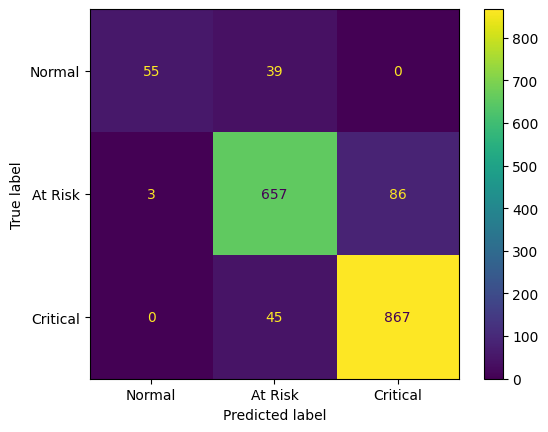

In [ ]:
# Train a Random Forest Classifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

# Get accuracy of the model
# -------------------------
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

# compute confusion matrix
# ------------------------
labels = ['Normal','At Risk', 'Critical']
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Show side-by-side comparison of predicted results VS actual results
results = {'Predicted': y_pred, 'Actual': y_test}
results_df = pd.DataFrame(results)
print(results_df)

     Predicted    Actual
6056  Critical  Critical
5556  Critical  Critical
5990  Critical   At Risk
7674   At Risk    Normal
3319  Critical  Critical
...        ...       ...
8307  Critical  Critical
100     Normal    Normal
6605  Critical  Critical
1783   At Risk   At Risk
6013   At Risk   At Risk

[1752 rows x 2 columns]


<b>Results</b>

1) Testing accuracy is approximately 0.9 which implies a ~90% model accuracy (i.e. 90% chance that the model will predict a patient's condition correctly).

2) Model has a precision of approximately 0.9 for 'Normal', 'At Risk' and 'Critical', meaning that our model is highly precise in its predictions.

3) Although the recall value for 'Normal' is lower than 'At Risk' and 'Critical', this model aims to maximise the recall for 'At Risk' and 'Critical' patients as the cost of misclassifying these patients is more costly (E.g. predicting that a patient is 'At Risk' when they are actually 'Critical' could lead to potentially fatal consequences (e.g. Health complications)).

# Part 4: Additional information


In [ ]:
# Shows the importance of all the features used in the Random Forest Classifier model
test = model.feature_importances_
importance = pd.DataFrame(test, index=X.columns, columns=['Importance'])
importance.sort_values(by='Importance', ascending=False)

,Importance
Diastolic BP,0.149316
Systolic BP,0.137223
Blood Glucose,0.136761
Oxygen Saturation,0.128834
Heart Rate,0.123451
Body Temp,0.097623
Activity Level,0.062371
Age,0.036422
Smoking Status_Yes,0.034038
Number of Medications,0.027741


In [ ]:
# Generate a small test dataset to test & validate the accuracy of the model

# Number of records
num_records = 100

# Generate random timestamps
start_date = datetime(2024,12,31)
end_date = datetime(2025,12,31)
timestamps = []
for i in range(num_records):
    days = np.random.randint(0, (end_date - start_date).days)
    timestamp = start_date + timedelta(days=days) + timedelta(
            hours=np.random.randint(0, 23),
            minutes=np.random.randint(0, 59)
    )
    timestamps.append(timestamp)

# Generate demographic data
age = np.random.randint(60, 90, num_records)  # Age between 60 and 90
gender = np.random.choice(['Male', 'Female'], num_records)
disability_status = np.random.choice(['Yes', 'No'], num_records, p=[0.3, 0.7])  # 30% with disabilities

# Generate vital signs
heart_rate = np.random.randint(50, 120, num_records)
systolic_bp = np.random.randint(90, 180, num_records)
diastolic_bp = np.random.randint(60, 120, num_records)
blood_glucose = np.random.randint(70, 200, num_records)
oxygen_saturation = np.random.randint(85, 100, num_records)
body_temp = np.round(np.random.uniform(36.0, 38.5, num_records), 1)

# Generate medical history
chronic_conditions = np.random.choice(['None', 'Diabetes', 'Hypertension', 'Heart Disease'], num_records, p=[0.4, 0.3, 0.2, 0.1])
num_medications = np.random.randint(0, 10, num_records)

# Generate lifestyle factors
activity_level = np.random.randint(0, 5000, num_records)
smoking_status = np.random.choice(['Yes', 'No'], num_records, p=[0.2, 0.8])
alcohol_consumption = np.random.choice(['Yes', 'No'], num_records, p=[0.3, 0.7])

# Create DataFrame test
test = {
    'Age': age,
    'Gender': gender,
    'Disability Status': disability_status,
    'Heart Rate': heart_rate,
    'Systolic BP': systolic_bp,
    'Diastolic BP': diastolic_bp,
    'Blood Glucose': blood_glucose,
    'Oxygen Saturation': oxygen_saturation,
    'Body Temp': body_temp,
    'Chronic Conditions': chronic_conditions,
    'Number of Medications': num_medications,
    'Activity Level': activity_level,
    'Smoking Status': smoking_status,
    'Alcohol Consumption': alcohol_consumption,
    'Timestamp': timestamps
}

df2 = pd.DataFrame(test)
df2['Condition'] = df2.apply(generate_condition, axis=1)

# Drop 'Timestamp' column as it won't be needed
df2 = df2.drop(columns=['Timestamp'])

# Encode categorical variables
categorical_cols = ['Gender', 'Disability Status', 'Chronic Conditions', 'Smoking Status', 'Alcohol Consumption']
df2_encoded = pd.get_dummies(df2, columns=categorical_cols, drop_first=True)

# Separate features and target
X2 = df2_encoded.drop(columns=['Condition'])
y2 = df2_encoded['Condition']

# Scale numerical features
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

y2_pred = model.predict(X2_scaled)

results2 = {'Predicted': y2_pred, 'Actual': y2}
results_df2 = pd.DataFrame(results2)
accuracy = np.where(results_df2["Predicted"] == results_df2["Actual"], True, False)
accuracy_count = np.count_nonzero(accuracy)
accuracy_percent = 100 * accuracy_count / len(results_df2)
print(accuracy_percent)

86.0
